# EXTRAPOLATION sp-air 
Recall to select the myenv in the python kernel
"source activate myenv"

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
print(sys.version)

3.6.12 | packaged by conda-forge | (default, Dec  9 2020, 00:36:02) 
[GCC 9.3.0]


In [3]:
import time
import pickle
import os
import copy
import numpy

import numpy as np
import tensorflow as tf
from scipy.misc import imresize

import config
import model
import rat_spn

Instructions for updating:
Use the retry module or similar alternatives.


## Helper functions

In [27]:
def load_dataset_from_file(train_file, test_file, out_of_sample_test_file):
    loaded_train = numpy.load(train_file)
    loaded_test = numpy.load(test_file)
    loaded_test_out = numpy.load(out_of_sample_test_file)
    return (loaded_train['images'], 
            loaded_train['counts']), (loaded_test['images'], 
                                      loaded_test['counts']), (loaded_test_out['images'], 
                                                               loaded_test_out['counts'])

class SpnReconstructor:
    def __init__(self, spn):
        self.spn = spn
        self.input_ph = tf.placeholder(tf.float32, (1, spn.num_dims))
        self.marginalized = tf.placeholder(tf.float32, (1, spn.num_dims))
        self.spn_out = spn.forward(self.input_ph, self.marginalized)
        self.max_idx_tensors = {}
        for layer in spn.vector_list:
            for vector in layer:
                if isinstance(vector, rat_spn.SumVector):
                    self.max_idx_tensors[vector.name] = vector.max_child_idx

    def reconstruct(self, image, marginalized, sess, sample=False):
        original_shape = image.shape
        image = np.reshape(image, (1, -1))
        marginalized = np.reshape(marginalized, (1, -1))
        feed_dict = {self.input_ph: image, self.marginalized: marginalized}
        max_idxs = sess.run(self.max_idx_tensors, feed_dict=feed_dict)
        recon = self.spn.reconstruct(max_idxs, sess, sample)
        recon = recon * (1 - marginalized)
        recon = np.clip(recon, 0.0, 1.0)
        return np.reshape(recon, original_shape)


class SupairTrainer:
    def __init__(self, conf):
        
        
        # load data and add make sure that conf has the appropriate variables describing the dataset
        bboxes = None
        if conf.dataset == 'MNIST':
            (x, counts), (x_test, c_test), (x_test_out, c_test_out) = load_dataset_from_file(conf.train_file,
                                                                                             conf.test_file,
                                                                                             conf.out_test_file)
            conf.scene_width = x.shape[-3]
            conf.scene_height = x.shape[-2]
            conf.channels = x.shape[-1]
        else:
            raise ValueError('unknown dataset', conf.dataset)
        self.x, self.counts = x, counts
        self.x_test, self.c_test = x_test, c_test
        self.x_test_out, self.c_test_out = x_test_out, c_test_out
            
            
        
        self.conf = conf

        # determine and create result dir
        i = 1
        log_path = conf.result_path + 'run0'
        while os.path.exists(log_path):
            log_path = '{}run{}'.format(conf.result_path, i)
            i += 1
        os.makedirs(log_path)
        self.log_path = log_path

        if not os.path.exists(conf.checkpoint_dir):
            os.makedirs(conf.checkpoint_dir)

        input_shape = [conf.batch_size, conf.scene_width, conf.scene_height, conf.channels]
        # build model
        with tf.device(conf.device):
            self.mdl = model.Supair(conf)
            self.in_ph = tf.placeholder(tf.float32, input_shape)
            self.elbo = self.mdl.elbo(self.in_ph)

            self.mdl.num_parameters()

            self.optimizer = tf.train.AdamOptimizer()
            self.train_op = self.optimizer.minimize(-1 * self.elbo)

        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        if self.conf.load_params:
            resume_ckpt = os.path.join(self.conf.path_to_ckpt)
            self.saver.restore(self.sess, resume_ckpt)
        else:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(tf.local_variables_initializer())

        print('Built model')
        self.obj_reconstructor = SpnReconstructor(self.mdl.obj_spn)
        self.bg_reconstructor = SpnReconstructor(self.mdl.bg_spn)

        tfgraph = tf.get_default_graph()
        self.tensors_of_interest = {
            'z_where': tfgraph.get_tensor_by_name('z_where:0'),
            'z_pres': tfgraph.get_tensor_by_name('z_pres:0'),
            'bg_score': tfgraph.get_tensor_by_name('bg_score:0'),
            'y': tfgraph.get_tensor_by_name('y:0'),
            'obj_vis': tfgraph.get_tensor_by_name('obj_vis:0'),
            'bg_maps': tfgraph.get_tensor_by_name('bg_maps:0')
        }

    def log_and_print_progress(self, n_iter, acc, elbo, avg_obj, log_file, title):
        print('{}, N_iter {}, Accuracy: {}, avg_obj: {}, elbo {}'.format(title, n_iter, acc, avg_obj, elbo))
        log_file.write('{}, {}, {}, {}, {}\n'.format(title, n_iter, acc, avg_obj, elbo))
        log_file.flush()

    def reconstruct_scenes(self, images, cur_values):
        num_detected = np.sum(np.rint(cur_values['z_pres']), axis=1).astype(np.int32)
        results = []
        for i in range(images.shape[0]):
            n = int(num_detected[i])
            y = cur_values['y'][i]
            z_where = cur_values['z_where'][i]
            obj_vis = cur_values['obj_vis'][i]
            objects = [self.obj_reconstructor.reconstruct(y[k], 1 - obj_vis[k], self.sess)
                       for k in range(n)]
            bg_map = cur_values['bg_maps'][i, n]
            bg = self.bg_reconstructor.reconstruct(images[i], 1 - bg_map, self.sess, sample=True)

            for j in range(n - 1, -1, -1):
                col = int(z_where[j, 2])
                row = int(z_where[j, 5])
                w = int(z_where[j, 0] * self.conf.patch_width)
                h = int(z_where[j, 4] * self.conf.patch_height)
                # check for pathological object dimensions; treat as not present
                if h <= 0 or w <= 0 or row < 0 or col < 0 or row + h > 50 or col + w > 50:
                    continue
                obj = imresize(np.squeeze(objects[j]), (h, w)).astype(np.float32) / 255.0
                bg[row:row + h, col:col + w, 0] = obj

            results.append(bg)

        results = np.stack(results, 0)
        results = np.clip(results, 0.0, 1.0)
        return results

    def run_training(self):
        batch_size = self.conf.batch_size
        batches_per_epoch = self.x.shape[0] // batch_size
        sess = self.sess

        perf_log = open(self.conf.log_file, 'a')
        
        for n_iter in range(20000):
            i = n_iter % batches_per_epoch            
            batch = self.x[i * batch_size: (i + 1) * batch_size]
            
            # print("DEBUG ->",n_iter, i, batch.shape)
                 
            _, cur_elbo, cur_values = sess.run([self.train_op, self.elbo, self.tensors_of_interest], feed_dict={self.in_ph: batch})

            if (n_iter % 1000 ==0) and (n_iter > 0):
                # save the model 
                ckpt_file = os.path.join(self.conf.checkpoint_dir, "model_"+str(n_iter)+".ckpt")
                self.saver.save(sess, ckpt_file)
                
            if (n_iter % 100 == 0):
                # train accuracy
                num_detected = np.sum(np.rint(cur_values['z_pres']), axis=1).astype(np.int32)
                batch_counts = self.counts[i * batch_size: (i + 1) * batch_size]
                train_acc = np.mean(num_detected == batch_counts)
                avg_obj = np.average(num_detected)
                self.log_and_print_progress(n_iter, train_acc, cur_elbo, avg_obj, perf_log, title="train")
                    
            if (n_iter % 1000 == 0) and (n_iter > 0):
                print("computing test acc")
                test_elbo = 0
                test_acc, test_avg_obj = self.compute_test_acc(kind="in")
                self.log_and_print_progress(n_iter, test_acc, test_elbo, test_avg_obj, perf_log, title="test_in")
                test_acc, test_avg_obj = self.compute_test_acc(kind="out")
                self.log_and_print_progress(n_iter, test_acc, test_elbo, test_avg_obj, perf_log, title="test_out")
     
        perf_log.close()


    def compute_test_acc(self, kind):
        batch_size = self.conf.batch_size
        
        if kind == "in":
            num_batches = self.x_test.shape[0] // batch_size 
        elif kind == "out":
            num_batches = self.x_test_out.shape[0] // batch_size 
        else:
            raise ValueError('unknown kind', kind)
            
        z_pres = self.tensors_of_interest['z_pres']
        correct, num_detected_tot = 0, 0
        for i in range(num_batches):
            
            if kind == "in":
                x_batch = self.x_test[i * batch_size: (i + 1) * batch_size]
                c_batch = self.c_test[i * batch_size: (i + 1) * batch_size]
            elif kind == "out":
                x_batch = self.x_test_out[i * batch_size: (i + 1) * batch_size]
                c_batch = self.c_test_out[i * batch_size: (i + 1) * batch_size]
            else:
                raise ValueError('unknown kind', kind)

            cur_pres = self.sess.run(z_pres, feed_dict={self.in_ph: x_batch})
            num_detected = np.sum(np.rint(cur_pres), axis=1)
            correct += np.sum(num_detected == c_batch)
            num_detected_tot += np.sum(num_detected)
        test_acc = correct / (num_batches * batch_size)
        avg_obj = num_detected_tot / (num_batches * batch_size)
        return test_acc, avg_obj
    
    
def grid_images(images, ncol=8, figsize=(12, 8)):
    nrow = int(numpy.ceil(float(images.shape[0]) / ncol))
    
    fig, ax = plt.subplots(ncols=ncol, nrows=nrow, figsize=figsize)
    for i in range(images.shape[0]):
        c,r = i % ncol, i // ncol
        ax[r,c].imshow(images[i,...,0], cmap='gray')
        ax[r,c].set_axis_off()
        
    plt.close(fig)
    return fig

In [47]:
conf = config.SupairConfig()
conf.visual = False

# data config
conf.dataset = 'MNIST'  # select dataset from 'MNIST', 'sprites', 'omniglot'

# ORIGINAL
# conf.train_file = '../processed_dataset/their_mnist_train.npz'
# conf.test_file = '../processed_dataset/their_mnist_test.npz'
# conf.out_test_file = '../processed_dataset/their_mnist_test.npz'
# conf.checkpoint_dir = 'checkpoints_original'
# conf.log_file = 'original-log_v7.csv'
# conf.min_obj_scale = 0.3  # bounds for width of bounding box relative to native width=28
# conf.max_obj_scale = 0.9  # bounds for width of bounding box relative to native width=28

# EXTRAPOLATION NO GRID
conf.train_file = '../processed_dataset/mnist_train_80x80_n0_3_no_grid.npz'
conf.test_file = '../processed_dataset/mnist_test_80x80_n0_3_no_grid.npz'
conf.out_test_file = '../processed_dataset/mnist_test_80x80_n4_6_no_grid.npz'
conf.checkpoint_dir = 'checkpoints_extrapolation_no_grid'
conf.log_file = 'extrapolation_no_grid-log.csv'
conf.min_obj_scale = 0.5  # bounds for width of bounding box relative to native width=28
conf.max_obj_scale = 1.5  # bounds for width of bounding box relative to native width=28
    

conf.noise = False  # add Gaussian noise
conf.structured_noise = True  # add background grid
conf.background_model = True  # use learned background model

conf.num_steps = 6  # maximum number of digits
conf.dataset = 'MNIST'  # select MNIST

# learning config
conf.load_params = False
conf.save_params = True

conf.batch_size = 64 # default is 256

# Convert their dataset in our format

In [48]:
#(x, counts), (x_test, c_test) = datasets.load_mnist(conf.scene_width, max_digits=2, path=conf.data_path)
#
#numpy.savez_compressed("their_mnist_train", images=x, counts=counts)
#numpy.savez_compressed("their_mnist_test", images=x_test, counts=c_test)

# Check the dataset

In [51]:
(x, counts), (x_test, c_test), (x_test_out, c_test_out)= load_dataset_from_file(conf.train_file,
                                                                                conf.test_file,
                                                                                conf.out_test_file)


print(x.shape, x_test.shape, x_test_out.shape)

(4000, 80, 80, 1) (4000, 80, 80, 1) (3000, 80, 80, 1)


[3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3]


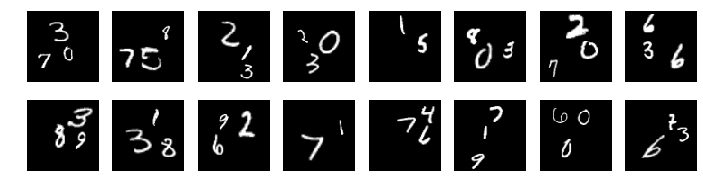

In [54]:
images = x[0:16]
print(counts[0:16])
grid_images(images[:16], figsize=(12,3))   

# Do the training

In [ ]:
tf.reset_default_graph()
trainer = SupairTrainer(conf)
trainer.run_training()
#tf.reset_default_graph()

Number of trainable parameters:
rnn 6830077
obj-spn 286560
bg-spn 230508
TOTAL 7347145
Built model
train, N_iter 0, Accuracy: 0.0, avg_obj: 0.0, elbo 350.1744689941406
train, N_iter 100, Accuracy: 0.828125, avg_obj: 0.828125, elbo 2558.64208984375
train, N_iter 200, Accuracy: 0.125, avg_obj: 1.984375, elbo 1551.990478515625
train, N_iter 300, Accuracy: 1.0, avg_obj: 0.0, elbo 3543.276123046875
train, N_iter 400, Accuracy: 0.671875, avg_obj: 1.8125, elbo 2647.282470703125


### Look at the model after training

In [19]:
cur_values_train = trainer.sess.run(trainer.tensors_of_interest, feed_dict={trainer.in_ph: x[:conf.batch_size]})
cur_values_test = trainer.sess.run(trainer.tensors_of_interest, feed_dict={trainer.in_ph: x_test[:conf.batch_size]})
cur_values_test_out = trainer.sess.run(trainer.tensors_of_interest, feed_dict={trainer.in_ph: x_test_out[:conf.batch_size]})

In [20]:
results_train = trainer.reconstruct_scenes(x[:16], cur_values_train)
results_test = trainer.reconstruct_scenes(x_test[:16], cur_values_test)
results_test_out = trainer.reconstruct_scenes(x_test_out[:16], cur_values_test_out)

/opt/conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:130: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


# Train

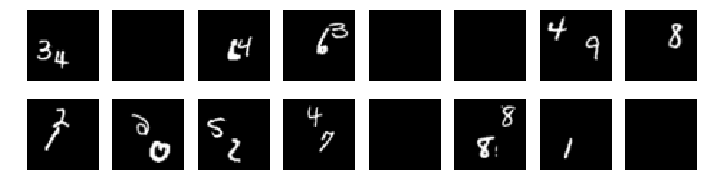

In [33]:
grid_images(x[:16], figsize=(12,3))

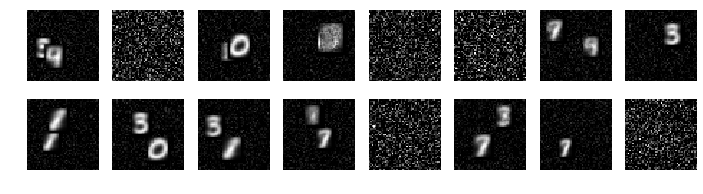

In [34]:
grid_images(results_train[:16], figsize=(12,3))

# Test

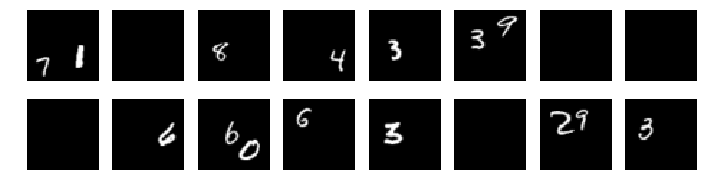

In [35]:
grid_images(x_test[:16], figsize=(12,3))

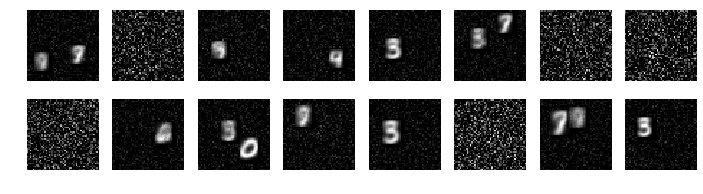

In [36]:
grid_images(results_test[:16], figsize=(12,3))

# Test_out

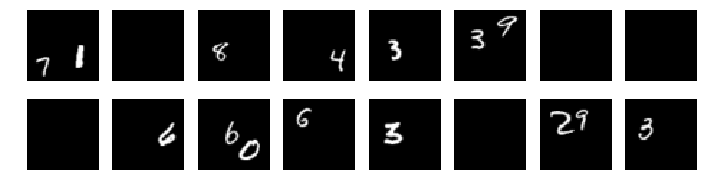

In [37]:
grid_images(x_test_out[:16], figsize=(12,3))

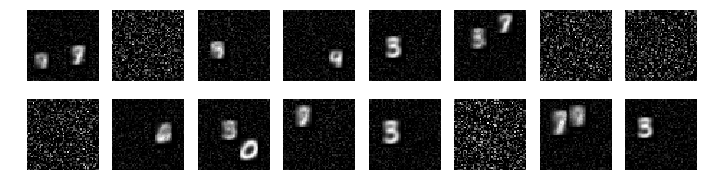

In [38]:
grid_images(results_test_out[:16], figsize=(12,3))